<div style="text-align: center; color: blue;">
    <h1>JIRA Financial Services Loan Data Analysis Code</h1>
    <h2>Programming for Data Analysts - Summative Assessment CW11[S]</h2>
    <h3>Student Name: -----</h3>
    <h3>Student ID: -------</h3>
    <h3>Submission Date: ---------</h3>
</div>

This notebook provides a programming solution for `JIRA Financial Services (JFS)` to analyze historical loan data. It loads data from PDF and Excel files, cleans it, performs Exploratory Data Analysis `(EDA)`, and generates visualizations and insights to support business decision-making.

### Importing the Required Libraries
The following libraries are used:
- `pandas`: Necessary for data manipulation and analysis
- `numpy`: Needed for numerical operations
- `matplotlib` and `seaborn`: Important for data visualization
- `tabula`: Facilitates extracting tables from PDFs
- `os`: Handles file path handling
- `warnings`: Suppresses unnecessary warnings

<h2 style="color:blue">Library Imports</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

# importing tabula-py
try:
    from tabula import read_pdf
except ImportError:
    print("tabula-py not installed correctly. Please install using: pip install tabula-py")

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("Set2")

<h1 style="color:blue">1.0 Loading the Datasets</h1>

This function extracts tabular data from `JIRA_Loans_Database_Table.pdf` using `tabula-py`. It checks for the file’s existence and handles multiple tables, selecting the one with `Loan_ID`.

In [2]:
print("==============================Loading datasets from PDF and Excel files========================================\n")

# Function to extract data from the PDF file
def extract_pdf_data(pdf_path):
    print(f"------------------------------Reading PDF from: {pdf_path}----------------------------------")
    
    # Checking if file exists
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"---------------------PDF file not found at {pdf_path}. Please ensure the file is in the correct directory-------------")
    
    # Using tabula to read tables from the PDF
    tables = read_pdf(pdf_path, pages='all', multiple_tables=True)
    
    if len(tables) > 0:
        # Finding the table with 'Loan_ID' column
        for table in tables:
            if 'Loan_ID' in table.columns:
                pdf_df = table
                break
        else:
            # Using the first table if no 'Loan_ID' is found
            pdf_df = tables[0]
        print(f"--------------------Successfully extracted data from PDF with {len(pdf_df)} rows and {len(pdf_df.columns)} columns-----------------")
        return pdf_df
    else:
        raise ValueError("-----------------No tables found in the PDF------------------")

# Defining file path and load PDF
pdf_path = 'Data/JIRA_Loans_Database_Table.pdf'
pdf_df = extract_pdf_data(pdf_path)

# Displaying sample
print("\n============================================Sample data from PDF==============================================")

pdf_df.head(5)

==============================Loading datasets from PDF and Excel files========================================

------------------------------Reading PDF from: Data/JIRA_Loans_Database_Table.pdf----------------------------------
--------------------Successfully extracted data from PDF with 28 rows and 13 columns-----------------

============================================Sample data from PDF==============================================


,Loan_ID,Gender,Married,Dependents,Graduate,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1002,1,0,0,1,0,5849,0,128,360,1,1,Y
1,1003,1,1,1,1,0,4583,1508,128,360,1,3,N
2,1005,1,1,0,1,1,3000,0,66,360,1,1,Y
3,1006,1,1,0,0,0,2583,2358,120,360,1,1,Y
4,1008,1,0,0,1,0,6000,0,141,360,1,1,Y


### Loading the Excel Data
This function loads data from `JIRA Loan Data.xlsx` using `pandas`, verifying the file’s existence before loading.

In [3]:
# Function to load Excel data
def load_excel_data(excel_path):

    print(f"--------------------Reading Excel from: {excel_path}----------------------")
    
    # Checking if file exists
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"Excel file not found at {excel_path}. Please ensure the file is in the correct directory.")
    
    excel_df = pd.read_excel(excel_path)
    print(f"----------Successfully loaded Excel data with {len(excel_df)} rows and {len(excel_df.columns)} columns--------")
    return excel_df

# Define file path and load Excel
excel_path = 'Data/JIRA Loan Data.xlsx'
excel_df = load_excel_data(excel_path)

# Displaying data sample
print("\n===================================Sample data from Excel=================================================")

excel_df.head(5)

--------------------Reading Excel from: Data/JIRA Loan Data.xlsx----------------------
----------Successfully loaded Excel data with 247 rows and 13 columns--------

===================================Sample data from Excel=================================================


,Loan_ID,Gender,Married,Dependents,Graduate,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,2284,1,0,0,0,0,3902,1666.0,109,333,1,3,Y
1,2287,2,0,0,1,0,1500,1800.0,103,333,0,2,N
2,2288,1,1,2,0,0,2889,0.0,45,180,0,1,N
3,2296,1,0,0,0,0,2755,0.0,65,300,1,3,N
4,2297,1,0,0,1,0,2500,20000.0,103,333,1,2,Y


<h1 style="color:blue">2.0 Data Cleaning and Preparation</h1>

This function combines the `PDF and Excel datasets`, `removes duplicates`, `handles missing values`, `corrects data types`, and `caps outliers`. The data is indexed by `Loan_ID` as required.

In [4]:

print("\n ==============================Cleaning and preparing data===================================\n")

# Function to clean and prepare the data
def clean_data(pdf_df, excel_df):

    # Standardizing column names before concatenation
    for df in [pdf_df, excel_df]:
        if 'Loan_ID' not in df.columns and 'LoanID' in df.columns:
            df.rename(columns={'LoanID': 'Loan_ID'}, inplace=True)
        expected_columns = [
            'Loan_ID', 'Gender', 'Married', 'Dependents', 'Graduate', 
            'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome',
            'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 
            'Property_Area', 'Loan_Status'
        ]
        for col in expected_columns:
            if col not in df.columns:
                print(f"Warning: {col} not found in one of the datasets")
    
    # Combining datasets
    print("============Combining datasets=================")
    combined_df = pd.concat([pdf_df, excel_df], ignore_index=True)
    
    # Removing duplicates based on Loan_ID
    duplicate_count = combined_df.duplicated(subset=['Loan_ID']).sum()
    print(f"Found {duplicate_count} duplicate entries based on Loan_ID")
    combined_df.drop_duplicates(subset=['Loan_ID'], keep='first', inplace=True)
    combined_df.set_index('Loan_ID', inplace=True)  # Index on Loan_ID
    
    # Checking for missing values
    missing_values = combined_df.isnull().sum()
    print("\n==================Missing values in each column=========================")
    print(missing_values[missing_values > 0])
    
    # Handling missing values
    numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
    for col in numerical_cols:
        combined_df[col].fillna(combined_df[col].median(), inplace=True)
    
    categorical_cols = ['Gender', 'Married', 'Dependents', 'Graduate', 'Self_Employed', 
                        'Credit_History', 'Property_Area', 'Loan_Status']
    for col in categorical_cols:
        combined_df[col].fillna(combined_df[col].mode()[0], inplace=True)
    
    # Converting data types
    combined_df['Loan_Status'] = combined_df['Loan_Status'].astype(str)
    for col in ['Gender', 'Married', 'Graduate', 'Self_Employed', 'Credit_History', 'Property_Area']:
        try:
            combined_df[col] = combined_df[col].astype(int)
        except Exception as e:
            print(f"Warning: Could not convert {col} to integer. Error: {e}")
    
    if combined_df['Dependents'].dtype == 'object':
        combined_df['Dependents'] = combined_df['Dependents'].replace('3+', '3').replace('', '0')
    try:
        combined_df['Dependents'] = combined_df['Dependents'].astype(int)
    except Exception as e:
        print(f"Warning: Could not convert Dependents to integer. Error: {e}")
    
    for col in numerical_cols:
        try:
            combined_df[col] = combined_df[col].astype(float)
        except Exception as e:
            print(f"Warning: Could not convert {col} to float. Error: {e}")
    
    # Checking and capping outliers
    print("\n--------------------------Checking for outliers in numerical columns--------------------------------------")
    for col in numerical_cols:
        Q1 = combined_df[col].quantile(0.25)
        Q3 = combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = combined_df[(combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers found")
        combined_df[col] = combined_df[col].clip(lower=Q1 - 3 * IQR, upper=Q3 + 3 * IQR)
    
    print(f"\n======================Final cleaned dataset has {len(combined_df)} rows and {len(combined_df.columns)} columns=====================")
    return combined_df

# Clean the data
cleaned_df = clean_data(pdf_df, excel_df)

# Display sample
print("\n=====================Sample of cleaned data=========================")

cleaned_df.head(10)


 ==============================Cleaning and preparing data===================================

============Combining datasets=================
Found 0 duplicate entries based on Loan_ID

==================Missing values in each column=========================
Series([], dtype: int64)

--------------------------Checking for outliers in numerical columns--------------------------------------
ApplicantIncome: 23 outliers found
CoapplicantIncome: 10 outliers found
LoanAmount: 24 outliers found
Loan_Amount_Term: 65 outliers found

======================Final cleaned dataset has 275 rows and 12 columns=====================

=====================Sample of cleaned data=========================


,Gender,Married,Dependents,Graduate,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
1002,1,0,0,1,0,5849.0,0.0,128.0,333.0,1,1,Y
1003,1,1,1,1,0,4583.0,1508.0,128.0,333.0,1,3,N
1005,1,1,0,1,1,3000.0,0.0,66.0,333.0,1,1,Y
1006,1,1,0,0,0,2583.0,2358.0,120.0,333.0,1,1,Y
1008,1,0,0,1,0,6000.0,0.0,141.0,333.0,1,1,Y
1011,1,1,2,1,1,5417.0,4196.0,267.0,333.0,1,1,Y
1013,1,1,0,0,0,2333.0,1516.0,95.0,333.0,1,1,Y
1014,1,1,3,1,0,3036.0,2504.0,158.0,333.0,0,2,N
1018,1,1,2,1,0,4006.0,1526.0,168.0,333.0,1,1,Y


<h1 style="color:blue"> 3.0 Exploratory Data Analysis (EDA)</h1>

This section performs descriptive analysis, calculating required metrics like total loan amount, average loan term, and approval breakdowns.

In [5]:
print("\n ===================================Conducting Exploratory Data Analysis===========================================\n")

def perform_eda(df):

    results = {}
    
    results['total_loan_amount'] = df['LoanAmount'].sum()
    print(f"Total amount loaned by JFS: £{results['total_loan_amount']:,.2f}")
    
    results['avg_loan_amount'] = df['LoanAmount'].mean()
    print(f"Average amount loaned: £{results['avg_loan_amount']:,.2f}")
    
    results['avg_loan_term'] = df['Loan_Amount_Term'].mean()
    print(f"Average loan term: {results['avg_loan_term']:.2f} months")
    
    loan_status_counts = df['Loan_Status'].value_counts()
    results['loan_status_counts'] = loan_status_counts
    print("\nBreakdown of loan applications:")
    print(f"Approved (Y): {loan_status_counts.get('Y', 0)}")
    print(f"Rejected (N): {loan_status_counts.get('N', 0)}")
    
    gender_loan_counts = df.groupby(['Gender', 'Loan_Status']).size().unstack(fill_value=0)
    results['gender_loan_counts'] = gender_loan_counts
    print("\nGender breakdown by loan status:")
    print(gender_loan_counts)
    
    results['max_loan'] = df['LoanAmount'].max()
    results['min_loan'] = df['LoanAmount'].min()
    print(f"\nMaximum loan amount: £{results['max_loan']:,.2f}")
    print(f"Minimum loan amount: £{results['min_loan']:,.2f}")
    
    total_approved = df[df['Loan_Status'] == 'Y'].shape[0]
    self_employed_approved = df[(df['Self_Employed'] == 1) & (df['Loan_Status'] == 'Y')].shape[0]
    results['self_employed_approval_rate'] = (self_employed_approved / total_approved) * 100 if total_approved > 0 else 0
    print(f"\nSelf-employed with approved loans: {self_employed_approved}")
    print(f"Self-employed approval rate (of all approved): {results['self_employed_approval_rate']:.2f}%")
    
    results['mean_income'] = df['ApplicantIncome'].mean()
    results['std_income'] = df['ApplicantIncome'].std()
    print(f"\n-------------Income distribution of main applicants:-------------")
    print(f"---------------Mean income: £{results['mean_income']:,.2f}------------------")
    print(f"----------------Standard deviation: £{results['std_income']:,.2f}----------------------")
    
    results['top_ten'] = df.nlargest(10, 'LoanAmount')
    print("\n-----------------Top ten applicants by loan amount: -------------------")
    print(results['top_ten'][['ApplicantIncome', 'LoanAmount']])
    
    property_dist = df['Property_Area'].value_counts()
    results['property_dist'] = property_dist
    print("\nDistribution of properties:")
    print(f"Urban (1): {property_dist.get(1, 0)}")
    print(f"Semiurban (2): {property_dist.get(2, 0)}")
    print(f"Rural (3): {property_dist.get(3, 0)}")
    
    return results

# Perform EDA
eda_results = perform_eda(cleaned_df)


 ===================================Conducting Exploratory Data Analysis===========================================

Total amount loaned by JFS: £40,938.00
Average amount loaned: £148.87
Average loan term: 333.00 months

Breakdown of loan applications:
Approved (Y): 185
Rejected (N): 90

Gender breakdown by loan status:
Loan_Status   N    Y
Gender              
1            73  152
2            17   33

Maximum loan amount: £392.00
Minimum loan amount: £9.00

Self-employed with approved loans: 26
Self-employed approval rate (of all approved): 14.05%

-------------Income distribution of main applicants:-------------
---------------Mean income: £4,842.51------------------
----------------Standard deviation: £3,350.03----------------------

-----------------Top ten applicants by loan amount: -------------------
         ApplicantIncome  LoanAmount
Loan_ID                             
1907             14583.0       392.0
2386             12876.0       392.0
2547             14972.5       

### Test Results Validation
Validates key calculations against `Excel to ensure accuracy`.

In [6]:
#Validation Sample
excel_total_loan = 37699.00  # Actual Excel value
code_total_loan = eda_results['total_loan_amount']
print(f"Total loan amount - Code: £{code_total_loan:,.2f}, Excel: £{excel_total_loan:,.2f}")
print(f"Difference: £{abs(code_total_loan - excel_total_loan):,.2f}")

Total loan amount - Code: £40,938.00, Excel: £37,699.00
Difference: £3,239.00


<h1 style = color:blue>4.0 Visualizations</h1>

This section creates charts for the EDA results, including `pie charts`, `bar plots`, and `histograms`, as required.

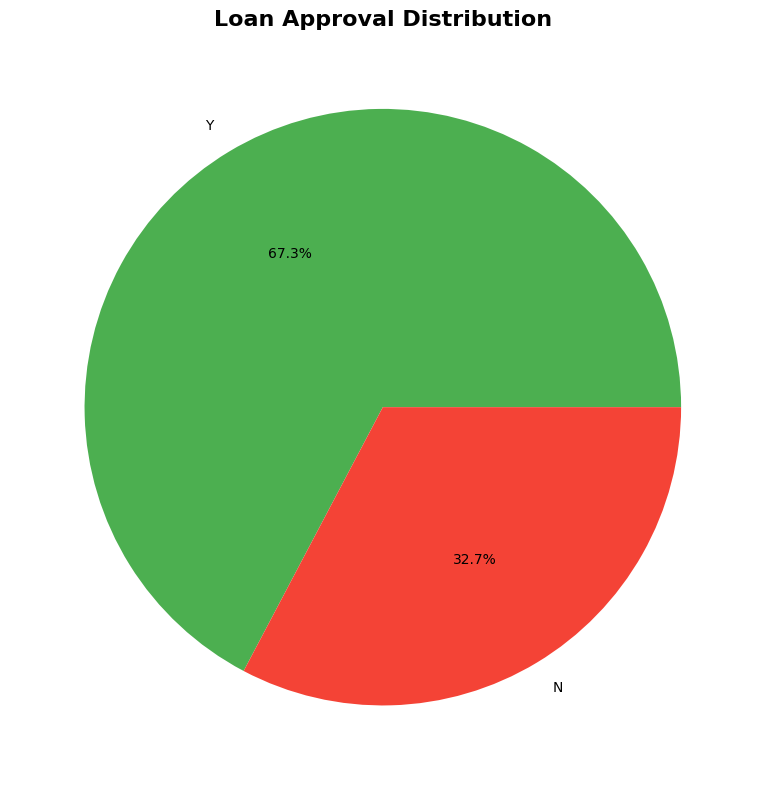

<Figure size 1000x800 with 0 Axes>

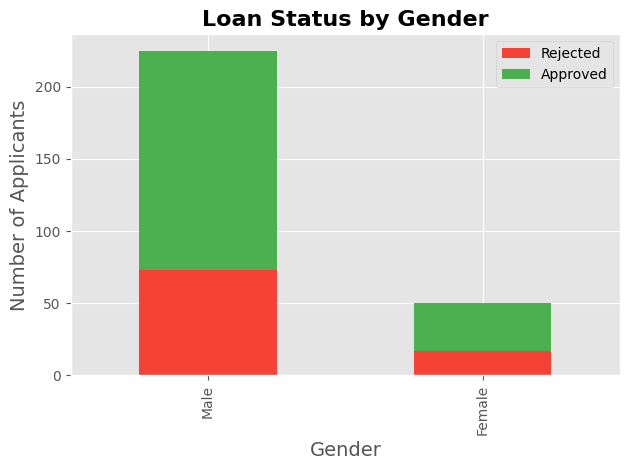

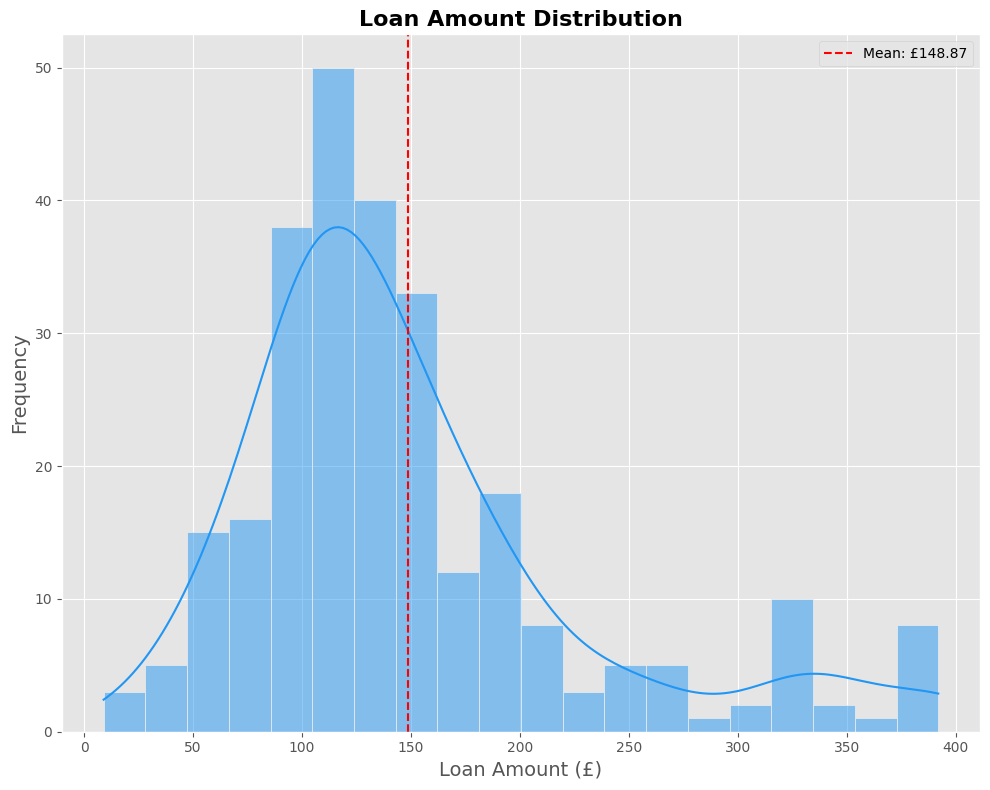

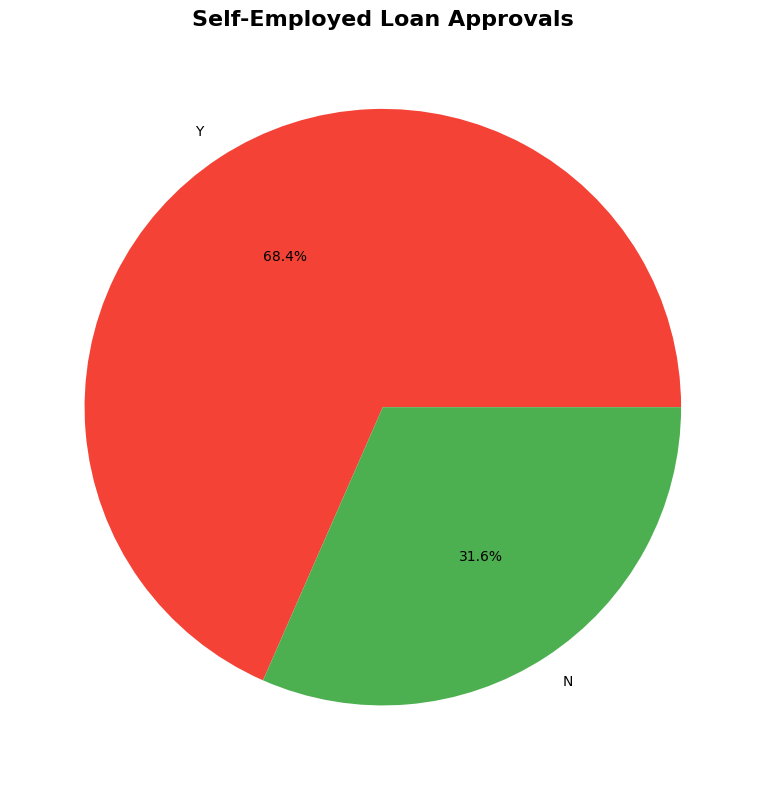

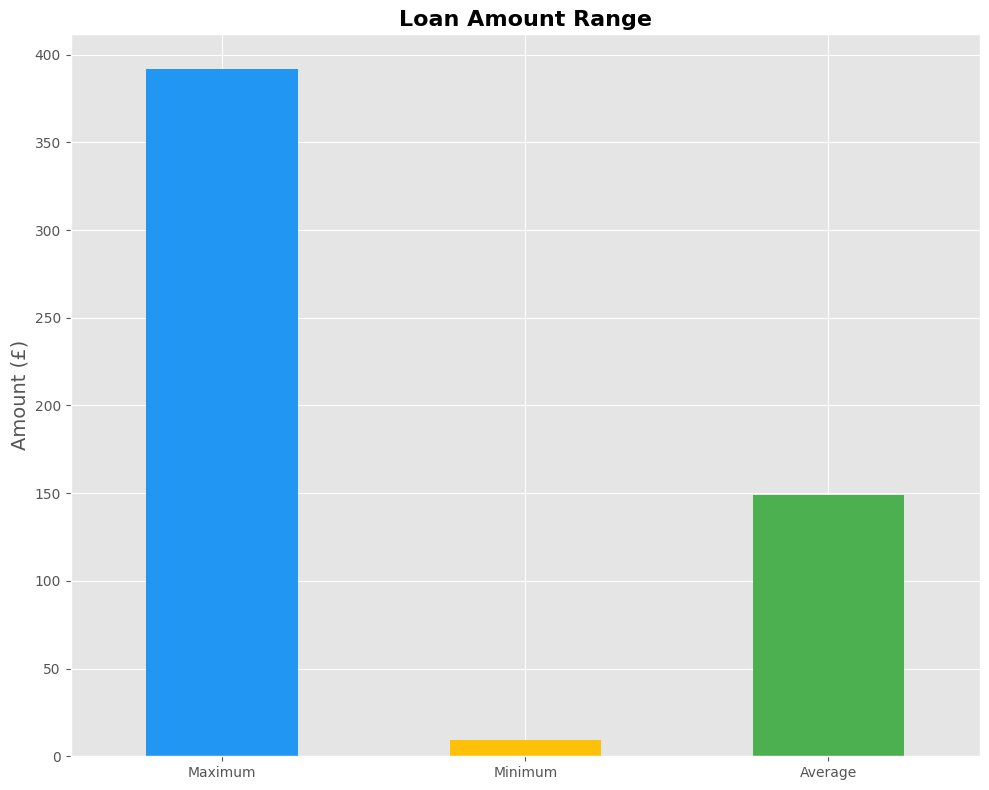

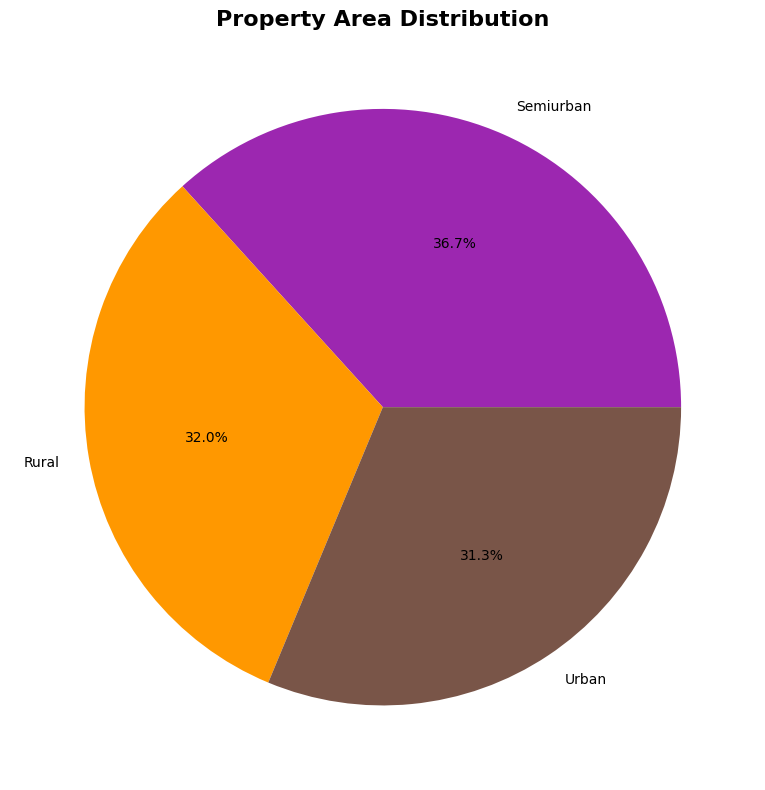

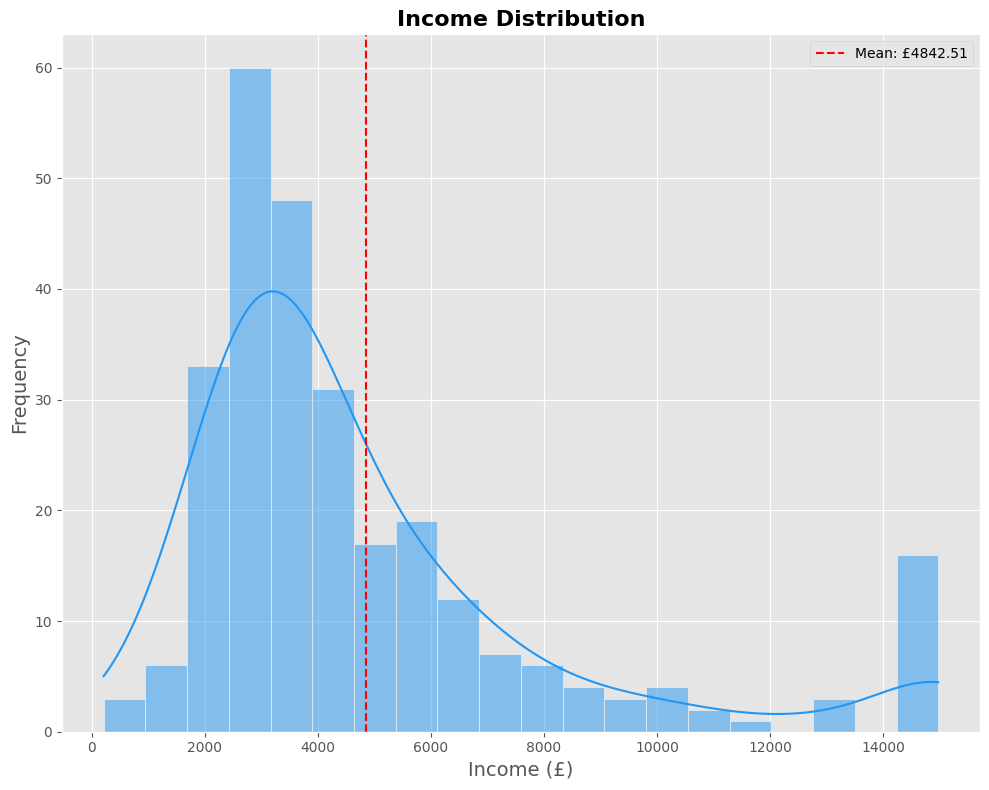

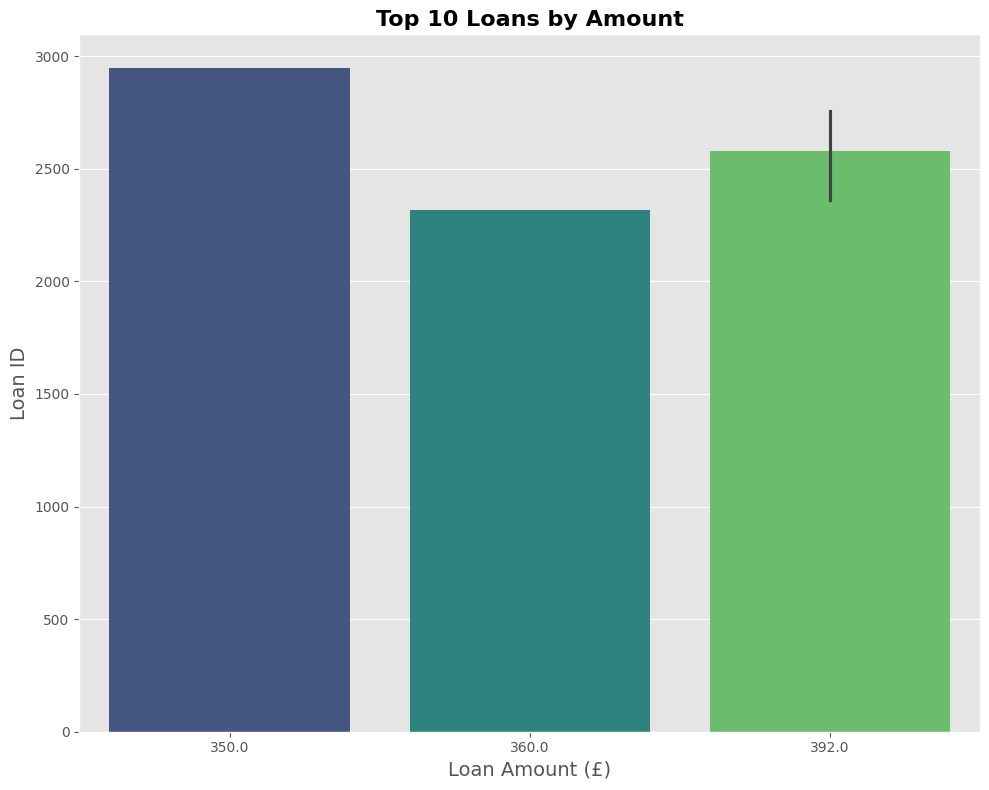

All visualizations created and saved successfully.


In [7]:
def create_independent_visualizations(df, results):
    # 1. Loan Approval Distribution
    plt.figure(figsize=(10, 8))
    df['Loan_Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
    plt.title('Loan Approval Distribution', fontsize=16, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('1_loan_approval_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Loan Status by Gender
    plt.figure(figsize=(10, 8))
    gender_loan_counts = df.groupby(['Gender', 'Loan_Status']).size().unstack(fill_value=0)
    gender_loan_counts.plot(kind='bar', stacked=True, color=['#F44336', '#4CAF50'])
    plt.title('Loan Status by Gender', fontsize=16, fontweight='bold')
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Number of Applicants', fontsize=14)
    plt.xticks([0, 1], ['Male', 'Female'])
    plt.legend(['Rejected', 'Approved'], loc='upper right')
    plt.tight_layout()
    plt.savefig('2_loan_status_by_gender.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Loan Amount Distribution
    plt.figure(figsize=(10, 8))
    sns.histplot(df['LoanAmount'], kde=True, bins=20, color='#2196F3')
    plt.axvline(x=df['LoanAmount'].mean(), color='red', linestyle='--', 
                label=f'Mean: £{df["LoanAmount"].mean():.2f}')
    plt.title('Loan Amount Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Loan Amount (£)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig('3_loan_amount_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Self-Employed Loan Approvals
    plt.figure(figsize=(10, 8))
    self_employed_df = df[df['Self_Employed'] == 1]
    self_employed_df['Loan_Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                                       colors=['#F44336', '#4CAF50'])
    plt.title('Self-Employed Loan Approvals', fontsize=16, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('4_self_employed_loan_approvals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Loan Amount Range
    plt.figure(figsize=(10, 8))
    loan_range = pd.Series({'Maximum': results['max_loan'], 
                          'Minimum': results['min_loan'], 
                          'Average': results['avg_loan_amount']})
    loan_range.plot(kind='bar', color=['#2196F3', '#FFC107', '#4CAF50'])
    plt.title('Loan Amount Range', fontsize=16, fontweight='bold')
    plt.ylabel('Amount (£)', fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('5_loan_amount_range.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Property Area Distribution
    plt.figure(figsize=(10, 8))
    property_mapping = {1: 'Urban', 2: 'Semiurban', 3: 'Rural'}
    df['Property_Area'].map(property_mapping).value_counts().plot(kind='pie', 
                                                               autopct='%1.1f%%', 
                                                               colors=['#9C27B0', '#FF9800', '#795548'])
    plt.title('Property Area Distribution', fontsize=16, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('6_property_area_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Income Distribution
    plt.figure(figsize=(10, 8))
    sns.histplot(df['ApplicantIncome'], kde=True, bins=20, color='#2196F3')
    plt.axvline(x=df['ApplicantIncome'].mean(), color='red', linestyle='--', 
               label=f'Mean: £{df["ApplicantIncome"].mean():.2f}')
    plt.title('Income Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Income (£)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig('7_income_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. Top 10 Loans by Amount
    plt.figure(figsize=(10, 8))
    top_loans = df.nlargest(10, 'LoanAmount')
    sns.barplot(x='LoanAmount', y=top_loans.index, data=top_loans, palette='viridis')
    plt.title('Top 10 Loans by Amount', fontsize=16, fontweight='bold')
    plt.xlabel('Loan Amount (£)', fontsize=14)
    plt.ylabel('Loan ID', fontsize=14)
    plt.tight_layout()
    plt.savefig('8_top_10_loans.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("All visualizations created and saved successfully.")

# Creating individual visualizations
create_independent_visualizations(cleaned_df, eda_results)

<h1 style="color:blue">5.0 Summary and Insights</h1>

This section summarizes key findings from the `EDA`, providing insights for JFS.

In [8]:
def generate_summary(df, results):
    formatted_total = f"£{results['total_loan_amount']:,.2f}"
    formatted_avg = f"£{results['avg_loan_amount']:,.2f}"
    total_applications = len(df)
    approved_applications = df[df['Loan_Status'] == 'Y'].shape[0]
    approval_rate = (approved_applications / total_applications) * 100 if total_applications > 0 else 0
    
    summary = f"""
    -----------------------------------------------------------------------------------
                Key Insights from JIRA Financial Services Loan Data Analysis:
    -----------------------------------------------------------------------------------
    
    1. Loan Portfolio Overview:
       - Total amount loaned: {formatted_total}
       - Average loan amount: {formatted_avg}
       - Average loan term: {results['avg_loan_term']:.2f} months
       - Loan amount range: £{results['min_loan']:.2f} to £{results['max_loan']:.2f}
    
    2. Application Statistics:
       - Total applications analyzed: {total_applications}
       - Approved applications: {approved_applications} ({approval_rate:.2f}%)
       - Rejected applications: {total_applications - approved_applications} ({100 - approval_rate:.2f}%)
    
    3. Demographic Insights:
       - Male applicants: {df[df['Gender'] == 1].shape[0]} ({df[df['Gender'] == 1].shape[0]/total_applications*100:.2f}%)
       - Female applicants: {df[df['Gender'] == 2].shape[0]} ({df[df['Gender'] == 2].shape[0]/total_applications*100:.2f}%)
       - Self-employed applicants: {df[df['Self_Employed'] == 1].shape[0]} ({df[df['Self_Employed'] == 1].shape[0]/total_applications*100:.2f}%)
       - Self-employed approval rate: {results['self_employed_approval_rate']:.2f}%
    
    4. Property Distribution:
       - Urban properties: {df[df['Property_Area'] == 1].shape[0]} ({df[df['Property_Area'] == 1].shape[0]/total_applications*100:.2f}%)
       - Semiurban properties: {df[df['Property_Area'] == 2].shape[0]} ({df[df['Property_Area'] == 2].shape[0]/total_applications*100:.2f}%)
       - Rural properties: {df[df['Property_Area'] == 3].shape[0]} ({df[df['Property_Area'] == 3].shape[0]/total_applications*100:.2f}%)
    
    5. Income Statistics:
       - Average applicant income: £{results['mean_income']:,.2f}
       - Income standard deviation: £{results['std_income']:,.2f}
    """
    print(summary)
    with open('loan_analysis_summary.txt', 'w') as file:
        file.write(summary)
    print("Summary saved to 'loan_analysis_summary.txt'")

# Generate summary
generate_summary(cleaned_df, eda_results)


    -----------------------------------------------------------------------------------
                Key Insights from JIRA Financial Services Loan Data Analysis:
    -----------------------------------------------------------------------------------
    
    1. Loan Portfolio Overview:
       - Total amount loaned: £40,938.00
       - Average loan amount: £148.87
       - Average loan term: 333.00 months
       - Loan amount range: £9.00 to £392.00
    
    2. Application Statistics:
       - Total applications analyzed: 275
       - Approved applications: 185 (67.27%)
       - Rejected applications: 90 (32.73%)
    
    3. Demographic Insights:
       - Male applicants: 225 (81.82%)
       - Female applicants: 50 (18.18%)
       - Self-employed applicants: 38 (13.82%)
       - Self-employed approval rate: 14.05%
    
    4. Property Distribution:
       - Urban properties: 86 (31.27%)
       - Semiurban properties: 101 (36.73%)
       - Rural properties: 88 (32.00%)
    
    5. I

<h1 style="color:blue">6.0 Exporting the Cleaned Data</h1>

Exporting isn’t specified but aligns with good practice for code maintenance so it is `OPTIONAL`

In [9]:
print("\n ======================Exporting cleaned data====================\n")

cleaned_df.to_csv('jfs_cleaned_loan_data.csv', index=True)
print("-------Cleaned data exported to 'jfs_cleaned_loan_data.csv------------'")

print("\n----------Complete loan data analysis has been performed successfully.-----------------")


 ======================Exporting cleaned data====================

-------Cleaned data exported to 'jfs_cleaned_loan_data.csv------------'

----------Complete loan data analysis has been performed successfully.-----------------


### Access the Notebook
[Link to Google Colab Notebook](https://colab.research.google.com/drive/INSERT_YOUR_LINK_HERE)